In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

import beir 
from beir import util, LoggingHandler
from beir.datasets.data_loader import GenericDataLoader
from beir.retrieval.evaluation import EvaluateRetrieval

from utils_func import corpus_processing, matrix_creation, clustering, retriever_model

#import optuna

import os
import multiprocessing
multiprocessing.set_start_method("spawn", force=True)

c:\Users\maxim\anaconda3\envs\research_ir\Lib\site-packages\beir\util.py:2: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


## Loading - Draft

In [2]:
# Example corpus and queries (replace with your actual data)

dataset = "nfcorpus"
url = "https://public.ukp.informatik.tu-darmstadt.de/thakur/BEIR/datasets/{}.zip".format(dataset)
data_path = util.download_and_unzip(url, "datasets")
data_path = f"datasets/{dataset}"
corpus, queries, qrels = GenericDataLoader(data_folder=data_path).load(split="test")

100%|██████████| 3633/3633 [00:00<00:00, 125828.08it/s]


In [3]:
embeddings = pd.read_csv(f'word_vectors_{dataset}.txt', sep=' ',na_values=[''], keep_default_na=False, index_col=0).dropna()
#embeddings.columns = ['word'] + [str(i) for i in range(100)]
for i in list(embeddings.columns)[1:]:
    embeddings[i] = embeddings[i].astype(float)

#embeddings = embeddings.set_index('word')

In [4]:
embeddings

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
126,-0.011044,0.058217,0.141033,-0.341268,-0.015768,0.003940,-0.175467,-0.144078,0.264548,-0.051928,...,-0.080752,0.664248,-0.297029,-0.210660,-0.193502,0.036609,-0.091867,0.359317,-0.082473,-0.490378
34.24,0.030947,-0.121440,0.054609,-0.084498,-0.053312,0.044570,-0.103145,-0.091805,0.036537,-0.045122,...,0.019651,0.182591,-0.135279,-0.033207,-0.109306,-0.005387,-0.088273,0.167130,-0.070896,-0.219247
35–52,0.014609,-0.021557,0.040719,-0.071937,-0.026585,0.028045,-0.034280,0.005987,0.067288,-0.032847,...,-0.012204,0.146577,-0.069230,-0.030009,-0.027265,0.013763,-0.022396,0.073876,-0.038226,-0.075663
nonenzymatic,0.027821,-0.350762,0.060792,-0.032954,-0.242349,0.270953,-0.284467,-0.016168,-0.130657,-0.119629,...,0.207984,0.083003,-0.060294,0.235988,0.176164,0.012528,-0.402212,0.179356,-0.328949,-0.324046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
nontyphoidal,0.056928,-0.387332,0.050045,0.097522,-0.089411,0.362372,-0.045939,-0.057368,-0.016160,-0.158027,...,0.195139,0.096966,-0.099858,0.119698,0.080288,0.038749,-0.155328,0.293395,-0.120318,-0.087386
insecticides,0.013313,-0.143795,0.092688,-0.050681,-0.050107,0.150434,0.139261,0.278535,-0.072205,-0.072606,...,0.075099,0.288328,-0.081073,-0.100547,0.132318,0.323047,0.244968,0.204230,0.050586,-0.325774
1735,0.029992,-0.085453,0.078009,-0.096499,-0.009471,0.093347,-0.063001,-0.031006,0.117415,-0.041062,...,-0.006004,0.271258,-0.207815,-0.066118,-0.093946,-0.022465,-0.043940,0.201661,-0.089507,-0.263998
-5.74,0.019313,-0.046945,0.045838,-0.091351,-0.050979,0.040370,-0.021837,-0.009942,0.060822,-0.028762,...,0.005205,0.176974,-0.072228,-0.016170,-0.054377,0.024676,-0.039392,0.077269,-0.006222,-0.110795


# Corpus cleaning - Draft

In [5]:
cleaned_corpus = corpus_processing.preprocess_corpus_dict(corpus)

100%|██████████| 3633/3633 [00:24<00:00, 149.13it/s]


In [6]:
cleaned_corpus

{'MED-10': 'statin use breast cancer survival nationwide cohort study finland recent study suggest statin establish drug group prevention cardiovascular mortality delay prevent breast cancer recurrence effect disease specific mortality remain unclear evaluate risk breast cancer death statin user population base cohort breast cancer patient study cohort include newly diagnose breast cancer patient finland 1995–2003 31,236 case identify finnish cancer registry information statin use diagnosis obtain national prescription database use cox proportional hazard regression method estimate mortality statin user statin use time dependent variable total 4,151 participant use statin median follow 3.25 year diagnosis range 0.08–9.0 year 6,011 participant die 3,619 60.2 breast cancer adjustment age tumor characteristic treatment selection post diagnostic pre diagnostic statin use associate lower risk breast cancer death hr 0.46 95 ci 0.38–0.55 hr 0.54 95 ci 0.44–0.67 respectively risk decrease post

In [6]:
def save_cleaned_corpus(cleaned_corpus, dataset):
    with open(f'cleaned_corpus_{dataset}.txt', 'w') as f:
        for key in tqdm(cleaned_corpus.keys()):
            f.write(f'{key}\t{cleaned_corpus[key]}\n')

def load_cleaned_corpus(path):
    cleaned_corpus = {}
    with open(path, 'r') as f:
        for line in tqdm(f):
            key, value = line.split('\t')
            cleaned_corpus[key] = value
    return cleaned_corpus

def save_text(text, path):
    with open(path, 'w') as f:
        f.write(text)

        
#save_cleaned_corpus(cleaned_corpus, dataset)

In [7]:
cleaned_corpus = load_cleaned_corpus(f'cleaned_corpus_{dataset}.txt')

0it [00:00, ?it/s]

382545it [00:01, 265862.60it/s]


In [ ]:
with open(f'text_{dataset}.txt', 'w') as f:
    for key in tqdm(cleaned_corpus.keys()):
        f.write(f'{cleaned_corpus[key]}')

## Test

In [6]:
def words_coexistence_probability(corpus:dict[int, str]) -> pd.DataFrame:
    """
    Function to calculate the probability of coexistence of each pair of words in the corpus
    :param corpus: dict[int, str] - a dictionary with the key being the document id and the value being the document text
    :return: pd.DataFrame - a dataframe with the probability of coexistence of each pair of words in the corpus
    """
    word_presence = matrix_creation.get_word_presence(corpus)
    unique_words = list(matrix_creation.get_unique_words(corpus))
    #word_coexistence = pd.DataFrame(0.0,index=unique_words, columns=unique_words)
    print("Calculating coexistence probability")
    word_coexistence = np.array([[len(word_presence[unique_words[word1]].intersection(word_presence[unique_words[word2]]))/max(len(word_presence[unique_words[word1]] | word_presence[unique_words[word2]]), 1) for word1 in range(len(unique_words))] for word2 in tqdm(range(len(unique_words)))])
    print("Creating dataframe")
    word_coexistence = pd.DataFrame(word_coexistence, index=unique_words, columns=unique_words)
    return word_coexistence

In [7]:
dico = dict()
word_presence = matrix_creation.get_word_presence(cleaned_corpus)
unique_words = list(matrix_creation.get_unique_words(cleaned_corpus))

for word2 in tqdm(range(len(unique_words))):
    dico[unique_words[word2]] = dict()
    for word1 in range(len(unique_words)):
        inter = len(word_presence[unique_words[word1]].intersection(word_presence[unique_words[word2]]))
        if inter > 0:
            dico[unique_words[word2]][unique_words[word1]] = inter/max(len(word_presence[unique_words[word1]] | word_presence[unique_words[word2]]), 1)

100%|██████████| 671/671 [00:00<00:00, 3162.12it/s]


In [8]:
class coex_matrix:
    def __init__(self, dico:dict[str, dict[str, float]], unique_words:list[str]):
        self.dico = dico
        self.index = unique_words
    def __getitem__(self, key:str):
        return self.dico[key]
    
    def loc(self, word):
        temp = np.zeros(len(self.index))
        for i in list(self.dico[word].keys()):
            temp[self.index.index(i)] = self.dico[word][i]
        return pd.Series(temp)

In [9]:
test = coex_matrix(dico, unique_words)

In [55]:
def get_replaceable_words(similarity_matrix:pd.DataFrame, coexistence_matrix:pd.DataFrame, alpha = 0.5, thresh = 0.8) -> dict[str, set[str]]:
    """
    Get for each word, the set of words that can replace it in a sentence according to the constraints on similarity and coexistence matrix.\n
    :param similarity_matrix: A pandas DataFrame containing the similarity matrix between words.\n
    :param coexistence_matrix: A pandas DataFrame containing the coexistence matrix between words.\n
    :param alpha: A float between 0 and 1, the weight of the similarity matrix in the final decision.\n
    :param thresh: A float between 0 and 1, the threshold to consider a word as a possible replacement.\n
    :return: A dictionary containing for each word, the set of words that can replace it in a sentence.
    """
    all_words = list(set(similarity_matrix.index).intersection(set(coexistence_matrix.index)))
    all_words.sort()
    to_ret = {}
    similarity_matrix.sort_index(inplace=True)
    if type(coexistence_matrix) == coex_matrix:
        coexistence_matrix.index = all_words
        for word in tqdm(all_words):
            temp = alpha * similarity_matrix.loc[word] + (1-alpha) * coexistence_matrix.loc(word)
            to_ret[word] = set(temp[temp > thresh].index)
    else:
        coexistence_matrix.sort_index(inplace=True)
        for word in tqdm(all_words):
            temp = alpha * similarity_matrix.loc[word] + (1-alpha) * coexistence_matrix.loc[word]
            to_ret[word] = set(temp[temp > thresh].index)

    return to_ret

In [56]:
get_replaceable_words(embeddings, test)

  0%|          | 0/37571 [00:00<?, ?it/s]


ValueError: 'psycarticle' is not in list

In [5]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

def words_coexistence_probability_compact(corpus: dict[int, str], thresh_prob: float = 0) -> 'coex_matrix':
    """
    Parallelized function to calculate the probability of coexistence of each pair of words in the corpus.
    """
    dico = {}
    word_presence = matrix_creation.get_word_presence(corpus)
    unique_words = list(matrix_creation.get_unique_words(corpus))

    def process_word(word2: str) -> tuple[str, dict]:
        inner_dict = {}
        set2 = word_presence[word2]
        for word1 in unique_words:
            set1 = word_presence[word1]
            inter = len(set1.intersection(set2))
            if inter > 0:
                union = len(set1.union(set2))
                prob = inter / max(union, 1)
                if prob > thresh_prob:
                    inner_dict[word1] = prob
        return (word2, inner_dict)

    with ThreadPoolExecutor() as executor:
        futures = {executor.submit(process_word, word2): word2 for word2 in unique_words}
        for future in tqdm(as_completed(futures), total=len(unique_words), desc="Processing words"):
            word2 = futures[future]
            result_word, inner_dict = future.result()
            assert word2 == result_word, "Mismatch between submitted and returned word"
            dico[word2] = inner_dict

    return coex_matrix(dico, unique_words)

In [7]:
words_coexistence_matrix = matrix_creation.words_coexistence_probability_compact(cleaned_corpus)

100%|██████████| 29043/29043 [08:32<00:00, 56.68it/s]


## End test

In [6]:
unique_words_corpus = set([word for doc in cleaned_corpus.values() for word in doc.split(" ")])

In [7]:
len(unique_words_corpus)

29051

# Matrix creation - Draft

In [8]:
#test = words_coexistence_probability({i:cleaned_corpus[i] for i in list(cleaned_corpus.keys())[:10]})
#words_coexistence_probability = matrix_creation.words_coexistence_probability

# Jaccard similarity
coexistence_matrix_path = f'words_coexistence_matrix_{dataset}_test.csv'
if os.path.exists(coexistence_matrix_path):
    words_coexistence_matrix = pd.read_csv(coexistence_matrix_path, na_values=[''])
    #words_coexistence_matrix.set_index('level_0', inplace=True)
    words_coexistence_matrix.index = words_coexistence_matrix.columns
else:
    words_coexistence_matrix = matrix_creation.words_coexistence_probability(cleaned_corpus)
    words_coexistence_matrix.to_csv('words_coexistence_matrix_nfcorpus_test.csv', index=False)

Getting unique words: 100%|██████████| 8674/8674 [00:00<00:00, 96272.79it/s]


Calculating coexistence probability


 30%|██▉       | 9041/30467 [06:02<12:32, 28.46it/s]

In [7]:
#cleaned_corpus = {i:cleaned_corpus[i] for i in list(cleaned_corpus.keys())[:10]}
words_coexistence_matrix = matrix_creation.words_coexistence_probability_compact(cleaned_corpus, thresh_prob=0.01)

100%|██████████| 29043/29043 [06:07<00:00, 79.04it/s]


In [7]:
coex_dict = words_coexistence_matrix.dico
list_vals = [list(coex_dict[words].values()) for words in list(coex_dict.keys())]

In [8]:
list_vals2 = []
for i in range(len(list_vals)):
    for j in range(len(list_vals[i])):
        list_vals2.append(list_vals[i][j])

(array([5.033660e+06, 2.109974e+06, 1.098820e+06, 5.712420e+05,
        3.496080e+05, 2.366520e+05, 1.529280e+05, 1.485120e+05,
        7.965800e+04, 7.961600e+04, 7.404400e+04, 6.298000e+03,
        7.560000e+04, 7.288600e+04, 4.030000e+03, 1.526000e+03,
        7.484400e+04, 3.024000e+03, 8.600000e+02, 8.002400e+04,
        5.020000e+02, 2.454000e+03, 4.540000e+02, 3.200000e+02,
        8.313200e+04, 1.660000e+02, 3.900000e+02, 1.040000e+02,
        1.986000e+03, 2.420000e+02, 1.820000e+02, 7.600000e+01,
        8.772400e+04, 2.400000e+01, 4.800000e+01, 4.200000e+01,
        8.000000e+01, 1.980000e+02, 5.800000e+01, 2.130000e+03,
        3.000000e+01, 5.200000e+01, 1.680000e+02, 3.000000e+01,
        6.400000e+01, 3.800000e+01, 1.800000e+01, 8.000000e+00,
        1.200000e+01, 1.064840e+05, 4.000000e+00, 1.600000e+01,
        1.000000e+01, 1.800000e+01, 1.800000e+01, 2.400000e+01,
        6.400000e+01, 1.000000e+01, 2.000000e+01, 1.160000e+02,
        6.000000e+00, 6.000000e+00, 2.40

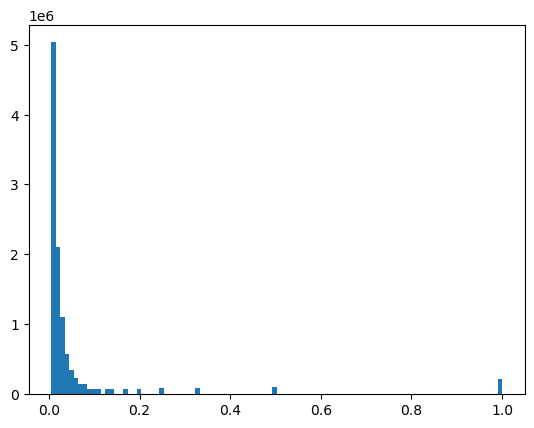

In [9]:
plt.hist(list_vals2, bins=100)

In [10]:
list_vals2 = np.array(list_vals2)
list_vals2[list_vals2 < 0.005].shape

(0,)

In [11]:
np.median(list_vals2)

0.016129032258064516

In [7]:
words_in_common = list(set(words_coexistence_matrix.index).intersection(set(embeddings.index)))

In [8]:
embeddings = embeddings.loc[words_in_common]

In [9]:
sim_mat = matrix_creation.get_similarity_matrix(embeddings[:], metric='cosine', n_neighbors=73)

In [10]:
words_in_common = list(set(words_coexistence_matrix.columns).intersection(set(embeddings.index)))

In [9]:
words_in_common

['rye',
 'mexiletine',
 'nonfirearm',
 'pregnenolone',
 'hotdog',
 'norfolk',
 'build',
 'lcds',
 'igs',
 'reperfusion',
 'electrophoretic',
 'grain',
 'uic',
 'antimetatstatic',
 'intervention',
 'athlete',
 'biotransforming',
 'seguimiento',
 'calciuria',
 'saharan',
 'scour',
 'uninfected',
 'microplate',
 'hydrolase',
 'nonlethal',
 'suspect',
 'disentangle',
 'qald',
 'folgende',
 'hypernatremia',
 'sy5y',
 'discrepant',
 'purchase',
 'faba',
 'modulatory',
 '48',
 'mutton',
 'relative',
 'immunosorbent',
 'papillomaviruse',
 'borobudur',
 'internationally',
 '2074',
 'tubo',
 'ardèche',
 'alt',
 'fractionate',
 '224',
 'tracer',
 '137',
 'extracorporeal',
 'aortic',
 'outrage',
 'ss',
 'impending',
 'everywhere',
 'wheezer',
 'congeners',
 '633',
 'evidently',
 'pessimistic',
 'scavenger',
 'insight',
 'cosponsor',
 'clip',
 'opposing',
 'underscore',
 'to',
 'tsnas',
 'cortisol',
 'skill',
 'horizontally',
 'resilience',
 'convincingly',
 'decarboxylase',
 '8014',
 'legitimate',

In [12]:
from concurrent.futures import ThreadPoolExecutor, as_completed

def get_replaceable_words(
    similarity_matrix: pd.DataFrame,
    coexistence_matrix: pd.DataFrame,
    alpha: float = 0.5,
    thresh: float = 0.8,
    max_workers: int = None
) -> dict[str, set[str]]:
    """
    Parallelized function to compute replaceable words using similarity and coexistence matrices.
    """
    # Get common words from both matrices
    all_words = list(set(similarity_matrix.index).intersection(coexistence_matrix.index))
    
    # Precompute the correct method to access coexistence_matrix data
    if isinstance(coexistence_matrix, matrix_creation.coex_matrix):
        get_coex = lambda word: coexistence_matrix.loc(word)
    else:
        get_coex = lambda word: coexistence_matrix.loc[word]

    # Dictionary to store results
    to_ret = {}

    def _process_word(word: str) -> tuple[str, set[str]]:
        """Helper function to compute replaceable words for a single word."""
        sim_row = similarity_matrix.loc[word]
        coex_row = get_coex(word)
        combined_score = alpha * sim_row + (1 - alpha) * coex_row
        return (word, set(combined_score[combined_score > thresh].index))

    # Parallelize word processing
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Submit all words for processing
        futures = {executor.submit(_process_word, word): word for word in all_words}
        
        # Track progress with tqdm
        for future in tqdm(as_completed(futures), total=len(all_words), desc="Processing words"):
            word = futures[future]
            result_word, replaceable_words = future.result()
            to_ret[result_word] = replaceable_words

    return to_ret

In [13]:
cpu = os.cpu_count()
cpu

16

In [ ]:
replaceable_words = get_replaceable_words(sim_mat, words_coexistence_matrix, alpha=0.5, thresh=0.8, max_workers=cpu)

Processing words:  31%|███       | 8903/29043 [17:49<40:20,  8.32it/s]  


In [10]:
replaceable_words = clustering.get_replaceable_words(sim_mat, words_coexistence_matrix, alpha=0.5, thresh=0.8)

  0%|          | 0/29043 [00:00<?, ?it/s]

  4%|▍         | 1287/29043 [00:31<11:14, 41.17it/s]


KeyboardInterrupt: 

In [11]:
word_graph = clustering.Graph(replaceable_words)

In [12]:
clusters = word_graph.find_all_cycles()
clusters

[{'rye'},
 {'mexiletine'},
 {'firearm', 'nonfirearm'},
 {'pregnenolone'},
 {'hotdog'},
 {'norfolk'},
 {'build'},
 {'lcds'},
 {'igs'},
 {'reperfusion'},
 {'electrophoretic'},
 {'uic'},
 {'grain'},
 {'antimetatstatic'},
 {'intervention'},
 {'athlete'},
 {'biotransforming'},
 {'navarra', 'seguimiento', 'universidad'},
 {'calciuria'},
 {'saharan'},
 {'scour'},
 {'uninfected'},
 {'microplate'},
 {'hydrolase'},
 {'nonlethal'},
 {'suspect'},
 {'disentangle'},
 {'qald'},
 {'erkrankungen', 'folgende', 'roggen', 'zeigen'},
 {'hypernatremia'},
 {'sy5y'},
 {'discrepant'},
 {'purchase'},
 {'faba'},
 {'modulatory'},
 {'48'},
 {'mutton'},
 {'relative'},
 {'immunosorbent'},
 {'papillomaviruse'},
 {'borobudur'},
 {'internationally'},
 {'2074'},
 {'tubo'},
 {'ardèche'},
 {'alt'},
 {'fractionate'},
 {'224'},
 {'tracer'},
 {'137'},
 {'extracorporeal'},
 {'aortic'},
 {'outrage'},
 {'ss'},
 {'impending'},
 {'everywhere'},
 {'wheezer'},
 {'congeners'},
 {'633'},
 {'evidently'},
 {'pessimistic'},
 {'scavenger

In [40]:
clusters.sort(key=lambda x: len(x), reverse=True)

In [41]:
clusters

[{'574',
  'accru',
  'ainsi',
  'algunos',
  'algún',
  'alor',
  'altas',
  'alto',
  'amplia',
  'asma',
  'asociaciones',
  'asociaron',
  'asoció',
  'autorreferida',
  'bajo',
  'basó',
  'cociente',
  'conclusión',
  'confianza',
  'connus',
  'conocido',
  'consumo',
  'contexte',
  'corporal',
  'corporelle',
  'diario',
  'diferencias',
  'différence',
  'débile',
  'embargo',
  'encuesta',
  'enfermedad',
  'entre',
  'estimer',
  'estimé',
  'estudio',
  'existen',
  'facteur',
  'factore',
  'familia',
  'familles',
  'feuille',
  'geográficas',
  'hebdomadaire',
  'hojas',
  'hombre',
  'hombres',
  'homme',
  'hortalizas',
  'ic95',
  'igual',
  'lait',
  'laitier',
  'logistique',
  'logística',
  'lácteo',
  'légumes',
  'marco',
  'marquées',
  'mujeres',
  'méthodes',
  'nacional',
  'observaron',
  'padecer',
  'padecerla',
  'parmi',
  'parte',
  'pequeña',
  'pollo',
  'posibilidades',
  'prevalencia',
  'probabilidad',
  'proporción',
  'prévalence',
  'quelconqu

In [13]:
clust_dict = clustering.clusters_dict(clusters)
clust_dict

{'rye': 0,
 'mexiletine': 1,
 'nonfirearm': 2,
 'firearm': 2,
 'pregnenolone': 3,
 'hotdog': 4,
 'norfolk': 5,
 'build': 6,
 'lcds': 7,
 'igs': 8,
 'reperfusion': 9,
 'electrophoretic': 10,
 'uic': 11,
 'grain': 12,
 'antimetatstatic': 13,
 'intervention': 14,
 'athlete': 15,
 'biotransforming': 16,
 'seguimiento': 17,
 'navarra': 17,
 'universidad': 17,
 'calciuria': 18,
 'saharan': 19,
 'scour': 20,
 'uninfected': 21,
 'microplate': 22,
 'hydrolase': 23,
 'nonlethal': 24,
 'suspect': 25,
 'disentangle': 26,
 'qald': 27,
 'roggen': 28,
 'folgende': 28,
 'erkrankungen': 28,
 'zeigen': 28,
 'hypernatremia': 29,
 'sy5y': 30,
 'discrepant': 31,
 'purchase': 32,
 'faba': 33,
 'modulatory': 34,
 '48': 35,
 'mutton': 36,
 'relative': 37,
 'immunosorbent': 38,
 'papillomaviruse': 39,
 'borobudur': 40,
 'internationally': 41,
 '2074': 42,
 'tubo': 43,
 'ardèche': 44,
 'alt': 45,
 'fractionate': 46,
 '224': 47,
 'tracer': 48,
 '137': 49,
 'extracorporeal': 50,
 'aortic': 51,
 'outrage': 52,
 's

In [14]:
#rewritten = rewrite_corpus({key:cleaned_corpus[key] for key in tqdm(list(cleaned_corpus.keys())[:10])}, clust_dict)
rewritten = clustering.rewrite_corpus(cleaned_corpus, clust_dict)

100%|██████████| 3633/3633 [01:14<00:00, 48.90it/s]


In [15]:
rewritten

{'MED-10': '9467 11211 14766 1850 18623 8133 18738 17979 8989 17816 6158 20737 721 17816 4332 2833 13907 9467 14152 11841 2069 8013 6631 785 13785 785 20982 7489 14357 1306 20631 18073 1850 18623 19089 14273 785 17537 17784 8642 4401 7489 1767 5059 12160 21211 7281 785 1850 18623 1060 6920 9467 19947 6631 18738 9736 21010 8989 785 1850 18623 4755 785 17816 8989 17443 12072 17997 18166 1850 18623 4755 6631 20737 11145 3607 11704 6158 785 2731 18623 16494 10137 17784 9467 11211 3609 14766 13768 785 21005 16124 5752 6158 18738 9437 6790 9315 12160 11211 785 10124 1489 1218 114 1765 67 129 7489 6920 9467 19947 12515 9467 11211 5111 21053 20507 17991 18738 2531 785 11906 4332 11211 9467 11145 785 19764 21269 15875 785 5220 13768 785 21005 5234 5220 11906 10402 785 20820 16124 13424 67 1850 18623 13768 130 13140 13523 3349 9443 14766 2932 1578 9532 7067 956 14766 1297 956 9467 11211 16124 18973 12515 17256 7281 785 1850 18623 1060 6362 169 2589 14766 6362 169 2589 20609 785 7281 5229 4992 70

# Retrieval - Draft

## BM25

In [3]:
from rank_bm25 import BM25Okapi
import optuna

class BM25_model:
  def __init__(self, corpus, k1=1.5, b=0.75):
    cleaned_corpus = corpus_processing.preprocess_corpus_dict(corpus)
    self.tokenized_corpus = [cleaned_corpus[key].split(" ") for key in corpus.keys()]
    self.bm25_model = BM25Okapi(self.tokenized_corpus, k1=k1, b=b)
    self.keys = list(corpus.keys())

  def search(self, corpus: dict[str, dict[str, str]], queries: dict[str, str], top_k: int, score_function,**kwargs) -> dict[str, dict[str, float]]:
    results = {}
    for query_id, query in tqdm(queries.items(), desc="tests in progress"):
        # Process the query
        #cleaned_query = preprocess_corpus([query])
        cleaned_query = corpus_processing.clean_tokens(corpus_processing.nlp(query))
        tokenized_query = cleaned_query.split(" ")
        # Apply BM25 to get scores
        scores = self.bm25_model.get_scores(tokenized_query)
        # Sort the scores in descending order and save the results
        ordered_keys_index = np.argsort(scores)[::-1][:top_k]
        sorted_scores = {self.keys[i] : scores[i] for i in ordered_keys_index}
        results[query_id] = sorted_scores
    return results
  

In [7]:
def objective(trial):
    # Suggest values for k1 and b
    k1 = trial.suggest_float("k1", 1.2, 2.0)  # Adjust range as needed
    b = trial.suggest_float("b", 0.0, 1.0)    # BM25's b typically lies between 0 and 1

    # Instantiate the retriever model with the suggested parameters
    retriever = BM25_model(cleaned_corpus, k1=k1, b=b)
    retriever_okapi = EvaluateRetrieval(retriever, score_function="cos_sim") # or "dot" if you wish dot-product
    results_okapi = retriever_okapi.retrieve(retriever.tokenized_corpus, queries)
    # Evaluate the model (implement your own evaluation logic, e.g., compute mean reciprocal rank)
    score = retriever_okapi.evaluate(qrels, results_okapi, retriever_okapi.k_values)[0]['NDCG@10']  # Replace this with your evaluation metric

    return score  # Higher score is better (Optuna minimizes by default)

study = optuna.create_study(direction="maximize")  # Use "minimize" if your score is a loss
study.optimize(objective, n_trials=100)

print(study.best_params)
print(study.best_value)

[I 2025-01-09 08:51:11,391] A new study created in memory with name: no-name-c149680f-eebe-4ccf-bdf4-8cc357b02ed7
tests in progress: 100%|██████████| 323/323 [00:03<00:00, 88.31it/s] 
[I 2025-01-09 08:51:15,806] Trial 0 finished with value: 0.30397 and parameters: {'k1': 1.689151112584689, 'b': 0.3743315999040079}. Best is trial 0 with value: 0.30397.
tests in progress: 100%|██████████| 323/323 [00:03<00:00, 98.46it/s] 
[I 2025-01-09 08:51:19,592] Trial 1 finished with value: 0.30198 and parameters: {'k1': 1.4126695191350203, 'b': 0.9045533710793888}. Best is trial 0 with value: 0.30397.
tests in progress: 100%|██████████| 323/323 [00:02<00:00, 108.99it/s]
[I 2025-01-09 08:51:23,051] Trial 2 finished with value: 0.30077 and parameters: {'k1': 1.3655081127949722, 'b': 0.023618988706922472}. Best is trial 0 with value: 0.30397.
tests in progress: 100%|██████████| 323/323 [00:02<00:00, 109.46it/s]
[I 2025-01-09 08:51:26,479] Trial 3 finished with value: 0.30204 and parameters: {'k1': 1.37

{'k1': 1.865819183429756, 'b': 0.48273398944742674}
0.30749


In [4]:
#k1=1.865819183429756, b=0.48273398944742674
model_bm25Okapi = BM25_model(corpus, k1=1.5, b=0.75)

100%|██████████| 382545/382545 [34:24<00:00, 185.29it/s]  


In [5]:
retriever_bm25Okapi = EvaluateRetrieval(model_bm25Okapi, score_function="cos_sim") # or "dot" if you wish dot-product

#### Retrieve dense results (format of results is identical to qrels)
#results = retriever.retrieve(corpus_to_give, {list(queries.keys())[i]:queries[list(queries.keys())[i]] for i in range(50)})
results_bm25Okapi = retriever_bm25Okapi.retrieve(model_bm25Okapi.tokenized_corpus, queries)

#### Evaluate your retrieval using NDCG@k, MAP@K ...
ndcg_bm25Okapi, _map_bm25Okapi, recall_bm25Okapi, precision_bm25Okapi = retriever_bm25Okapi.evaluate(qrels, results_bm25Okapi, retriever_bm25Okapi.k_values)

tests in progress: 100%|██████████| 49/49 [00:33<00:00,  1.48it/s]


In [7]:
ndcg_bm25Okapi, _map_bm25Okapi, recall_bm25Okapi, precision_bm25Okapi

({'NDCG@1': 0.40816,
  'NDCG@3': 0.3443,
  'NDCG@5': 0.34304,
  'NDCG@10': 0.3192,
  'NDCG@100': 0.44109,
  'NDCG@1000': 0.5437},
 {'MAP@1': 0.02626,
  'MAP@3': 0.0531,
  'MAP@5': 0.08385,
  'MAP@10': 0.12204,
  'MAP@100': 0.20358,
  'MAP@1000': 0.22042},
 {'Recall@1': 0.02626,
  'Recall@3': 0.07066,
  'Recall@5': 0.12439,
  'Recall@10': 0.20646,
  'Recall@100': 0.55401,
  'Recall@1000': 0.86524},
 {'P@1': 0.42857,
  'P@3': 0.34694,
  'P@5': 0.3551,
  'P@10': 0.30204,
  'P@100': 0.09286,
  'P@1000': 0.01612})

## Mine

In [16]:
def objective(trial):
    # Suggest values for k1 and b
    k1 = trial.suggest_float("k1", 1.2, 2.0)  # Adjust range as needed
    #b = trial.suggest_float("b", 0.0, 1.0)    # BM25's b typically lies between 0 and 1
    b = 0.75

    # Instantiate the retriever model with the suggested parameters
    retriever = retriever_model.Retriever(rewritten, clust_dict, k1=k1, b=b)
    retriever_okapi = EvaluateRetrieval(retriever, score_function="cos_sim") # or "dot" if you wish dot-product
    results_okapi = retriever_okapi.retrieve(retriever.tokenized_corpus, queries)
    # Evaluate the model (implement your own evaluation logic, e.g., compute mean reciprocal rank)
    score = retriever_okapi.evaluate(qrels, results_okapi, retriever_okapi.k_values)[0]['NDCG@10']  # Replace this with your evaluation metric

    return score  # Higher score is better (Optuna minimizes by default)

study = optuna.create_study(direction="maximize")  # Use "minimize" if your score is a loss
study.optimize(objective, n_trials=100)

print(study.best_params)
print(study.best_value)


[I 2025-01-10 14:55:19,815] A new study created in memory with name: no-name-931bfa38-066e-439d-bbdf-2aadd0f4c0fe
tests in progress: 100%|██████████| 323/323 [00:05<00:00, 57.87it/s]
[I 2025-01-10 14:55:26,214] Trial 0 finished with value: 0.29995 and parameters: {'k1': 1.2287223545403996}. Best is trial 0 with value: 0.29995.
tests in progress: 100%|██████████| 323/323 [00:04<00:00, 65.16it/s]
[I 2025-01-10 14:55:31,717] Trial 1 finished with value: 0.30066 and parameters: {'k1': 1.2750775582117548}. Best is trial 1 with value: 0.30066.
tests in progress: 100%|██████████| 323/323 [00:04<00:00, 64.90it/s]
[I 2025-01-10 14:55:37,240] Trial 2 finished with value: 0.30235 and parameters: {'k1': 1.963075281282854}. Best is trial 2 with value: 0.30235.
tests in progress: 100%|██████████| 323/323 [00:05<00:00, 63.59it/s]
[I 2025-01-10 14:55:42,921] Trial 3 finished with value: 0.30364 and parameters: {'k1': 1.5474879988686085}. Best is trial 3 with value: 0.30364.
tests in progress: 100%|███

{'k1': 1.609218899336134}
0.30398


In [23]:
# k1= 1.8891134483579508, b=0.4800276968019695
# base : k1 = 1.5, b = 0.75
model_okapi = retriever_model.Retriever(rewritten, clust_dict, k1= 1.61, b=0.75)

In [24]:
retriever_okapi = EvaluateRetrieval(model_okapi, score_function="cos_sim") # or "dot" if you wish dot-product

#### Retrieve dense results (format of results is identical to qrels)
#results = retriever.retrieve(corpus_to_give, {list(queries.keys())[i]:queries[list(queries.keys())[i]] for i in range(50)})
results_okapi = retriever_okapi.retrieve(model_okapi.tokenized_corpus, queries)

#### Evaluate your retrieval using NDCG@k, MAP@K ...
ndcg_okapi, _map_okapi, recall_okapi, precision_okapi = retriever_okapi.evaluate(qrels, results_okapi, retriever_okapi.k_values)


tests in progress: 100%|██████████| 323/323 [00:03<00:00, 88.91it/s] 


In [25]:
ndcg_okapi, _map_okapi, recall_okapi, precision_okapi

({'NDCG@1': 0.40093,
  'NDCG@3': 0.36413,
  'NDCG@5': 0.33404,
  'NDCG@10': 0.30398,
  'NDCG@100': 0.26349,
  'NDCG@1000': 0.32944},
 {'MAP@1': 0.05252,
  'MAP@3': 0.09096,
  'MAP@5': 0.10017,
  'MAP@10': 0.11407,
  'MAP@100': 0.13616,
  'MAP@1000': 0.14687},
 {'Recall@1': 0.05252,
  'Recall@3': 0.10464,
  'Recall@5': 0.11888,
  'Recall@10': 0.14666,
  'Recall@100': 0.24512,
  'Recall@1000': 0.46568},
 {'P@1': 0.40867,
  'P@3': 0.33746,
  'P@5': 0.2805,
  'P@10': 0.21734,
  'P@100': 0.06458,
  'P@1000': 0.01771})

In [ ]:
indexes = list(ndcg_okapi.keys()) + list(_map_okapi.keys()) + list(recall_okapi.keys()) + list(precision_okapi.keys())

values_mine_okapi = list(ndcg_okapi.values()) + list(_map_okapi.values()) + list(recall_okapi.values()) + list(precision_okapi.values())
values_bm25Okapi = list(ndcg_bm25Okapi.values()) + list(_map_bm25Okapi.values()) + list(recall_bm25Okapi.values()) + list(precision_bm25Okapi.values())

comparison = pd.DataFrame({'indexes':indexes, 'mine_okapi':values_mine_okapi, 'bm25Okapi':values_bm25Okapi})
comparison.columns = ['metrics', 'mine_okapi', 'bm25Okapi']
comparison.set_index('metrics', inplace=True)

comparison['diff'] = comparison['mine_okapi'] - comparison['bm25Okapi']
comparison

In [65]:
indexes = list(ndcg_okapi.keys()) + list(_map_okapi.keys()) + list(recall_okapi.keys()) + list(precision_okapi.keys())

values_mine_okapi = list(ndcg_okapi.values()) + list(_map_okapi.values()) + list(recall_okapi.values()) + list(precision_okapi.values())
#values_bm25Okapi = list(ndcg_bm25Okapi.values()) + list(_map_bm25Okapi.values()) + list(recall_bm25Okapi.values()) + list(precision_bm25Okapi.values())

comparison = pd.DataFrame({'indexes':indexes, 'mine_okapi':values_mine_okapi})#, 'bm25Okapi':values_bm25Okapi})
comparison.columns = ['metrics', 'mine_okapi']#, 'bm25Okapi']
comparison.set_index('metrics', inplace=True)

#comparison['diff'] = comparison['mine_okapi'] - comparison['bm25Okapi']
comparison.T.to_csv('comparison_nfcorpus.csv', index=False, mode = 'a')

In [35]:
print('Model better than bm25 for ' + str(comparison[comparison['diff'] > 0]['diff'].count()) + '/' + str(len(indexes))+ ' metrics')
print('Model worse than bm25 for ' + str(comparison[comparison['diff'] < 0]['diff'].count()) + '/' + str(len(indexes))+ ' metrics')
print('Model equal to bm25 for ' + str(comparison[comparison['diff'] == 0]['diff'].count()) + '/' + str(len(indexes))+ ' metrics')

Model better than bm25 for 5/24 metrics
Model worse than bm25 for 19/24 metrics
Model equal to bm25 for 0/24 metrics


## Finetuning

In [8]:
def objective(trial):
    # Suggest values for k1 and b
    #k1 = trial.suggest_float("k1", 1.2, 2.0)  # Adjust range as needed
    #b = trial.suggest_float("b", 0.0, 1.0)    # BM25's b typically lies between 0 and 1
    n_neighbors = trial.suggest_int("n_neighbors", 5, 100)
    alpha = trial.suggest_float("alpha", 0.3, 1.0)
    thresh = trial.suggest_float("thresh", 0.4, 1.0)
    #metric = trial.suggest_categorical("metric", ['cosine', 'euclidean'])
    metric = 'cosine'
    
    # Instantiate the retriever model with the suggested parameters
    retriever = retriever_model.FullRetriever(embeddings, n_neighbors = n_neighbors, alpha=alpha, thresh = thresh, metric = metric, k1 = 1.5, b = 0.75, coexistence_matrix = words_coexistence_matrix)
    retriever.fit(cleaned_corpus, is_clean=True)

    retriever_okapi = EvaluateRetrieval(retriever, score_function="cos_sim") # or "dot" if you wish dot-product
    results_okapi = retriever_okapi.retrieve(retriever.tokenized_corpus, queries)
    # Evaluate the model (implement your own evaluation logic, e.g., compute mean reciprocal rank)
    scores = retriever_okapi.evaluate(qrels, results_okapi, retriever_okapi.k_values)  # Replace this with your evaluation metric
    score = scores[0]['NDCG@10']

    ndcg_okapi, _map_okapi, recall_okapi, precision_okapi = scores
    indexes = list(ndcg_okapi.keys()) + list(_map_okapi.keys()) + list(recall_okapi.keys()) + list(precision_okapi.keys())

    values_mine_okapi = list(ndcg_okapi.values()) + list(_map_okapi.values()) + list(recall_okapi.values()) + list(precision_okapi.values())

    comparison = pd.DataFrame({'indexes':indexes, f'n_neighbors={n_neighbors} alpha={alpha} thresh={thresh} metric={metric}':values_mine_okapi})
    comparison.columns = ['metrics', f'n_neighbors={n_neighbors} alpha={alpha} thresh={thresh} metric={metric}']
    comparison.set_index('metrics', inplace=True)

    comparison.T.to_csv('comparison_nfcorpus.csv', index=True, mode = 'a', header=False)
    
    return score  # Higher score is better (Optuna minimizes by default)

study = optuna.create_study(direction="maximize")  # Use "minimize" if your score is a loss
study.optimize(objective, n_trials=100)

print(study.best_params)
print(study.best_value)

[I 2025-01-11 22:38:38,371] A new study created in memory with name: no-name-2364f87f-014c-4169-9c47-c1572b5f9bca
tests in progress: 100%|██████████| 323/323 [00:03<00:00, 91.99it/s] 
[I 2025-01-11 23:11:52,930] Trial 0 finished with value: 0.27838 and parameters: {'n_neighbors': 45, 'alpha': 0.8859024180037227, 'thresh': 0.7974211837509664}. Best is trial 0 with value: 0.27838.
tests in progress: 100%|██████████| 323/323 [00:03<00:00, 100.36it/s]
[I 2025-01-11 23:21:21,751] Trial 1 finished with value: 0.30364 and parameters: {'n_neighbors': 51, 'alpha': 0.3946918808963106, 'thresh': 0.7789542766435167}. Best is trial 1 with value: 0.30364.
tests in progress: 100%|██████████| 323/323 [00:03<00:00, 104.90it/s]
[I 2025-01-11 23:30:37,003] Trial 2 finished with value: 0.27711 and parameters: {'n_neighbors': 82, 'alpha': 0.4371255940196473, 'thresh': 0.46507622759811285}. Best is trial 1 with value: 0.30364.
tests in progress: 100%|██████████| 323/323 [00:03<00:00, 103.37it/s]
[I 2025-01-

{'n_neighbors': 73, 'alpha': 0.7618809756468575, 'thresh': 0.7543853066734008}
0.30843


In [14]:
'''
best_n_neighbors = study.best_params['n_neighbors']
best_alpha = study.best_params['alpha']
best_thresh = study.best_params['thresh']

best_n_neighbors, best_alpha, best_thresh
'''
'''
best_n_neighbors = 73
best_alpha = 0.7618809756468575

best_thresh = 0.7543853066734008
'''

best_n_neighbors = 75
best_alpha = 0.76
best_thresh = 0.75

In [15]:
retriever = retriever_model.FullRetriever(embeddings, n_neighbors = best_n_neighbors, alpha=best_alpha, thresh = best_thresh, metric = 'cosine', k1 = 1.5, b = 0.75, coexistence_matrix = words_coexistence_matrix)
retriever.fit(cleaned_corpus, is_clean=True)

retriever_okapi = EvaluateRetrieval(retriever, score_function="cos_sim") # or "dot" if you wish dot-product
results_okapi = retriever_okapi.retrieve(retriever.tokenized_corpus, queries)
# Evaluate the model (implement your own evaluation logic, e.g., compute mean reciprocal rank)
scores = retriever_okapi.evaluate(qrels, results_okapi, retriever_okapi.k_values)  # Replace this with your evaluation metric
scores

tests in progress: 100%|██████████| 323/323 [00:03<00:00, 96.39it/s] 


({'NDCG@1': 0.4226,
  'NDCG@3': 0.38654,
  'NDCG@5': 0.35634,
  'NDCG@10': 0.33018,
  'NDCG@100': 0.28173,
  'NDCG@1000': 0.34315},
 {'MAP@1': 0.05649,
  'MAP@3': 0.09281,
  'MAP@5': 0.10519,
  'MAP@10': 0.12232,
  'MAP@100': 0.14755,
  'MAP@1000': 0.15838},
 {'Recall@1': 0.05649,
  'Recall@3': 0.10263,
  'Recall@5': 0.12601,
  'Recall@10': 0.15951,
  'Recall@100': 0.2582,
  'Recall@1000': 0.46644},
 {'P@1': 0.43653,
  'P@3': 0.36017,
  'P@5': 0.30093,
  'P@10': 0.24211,
  'P@100': 0.06876,
  'P@1000': 0.0176})

In [44]:
from rank_bm25 import BM25Okapi, BM25L, BM25Plus
def objective(trial):
    # Suggest values for k1 and b
    k1 = trial.suggest_float("k1", 0.0, 2.0)  # Adjust range as needed
    b = trial.suggest_float("b", 0.0, 1.0)    # BM25's b typically lies between 0 and 1
    epsilon = trial.suggest_float("epsilon", 0.0, 1.0)
    #epsilon = 0.0
    #delta = 0.75

    # Instantiate the retriever model with the suggested parameters

    retriever.retriever.bm25_model = BM25Okapi(retriever.tokenized_corpus, k1=k1, b=b, epsilon=epsilon)
    retriever_okapi = EvaluateRetrieval(retriever, score_function="cos_sim") # or "dot" if you wish dot-product
    results_okapi = retriever_okapi.retrieve(retriever.tokenized_corpus, queries)
    # Evaluate the model (implement your own evaluation logic, e.g., compute mean reciprocal rank)
    score = retriever_okapi.evaluate(qrels, results_okapi, retriever_okapi.k_values)[0]['NDCG@10']  # Replace this with your evaluation metric

    return score  # Higher score is better (Optuna minimizes by default)

study = optuna.create_study(direction="maximize")  # Use "minimize" if your score is a loss
study.optimize(objective, n_trials=100)

print(study.best_params)
print(study.best_value)

[I 2025-01-13 21:47:08,012] A new study created in memory with name: no-name-16f7e08d-f51f-4803-9b7a-ba7e9dfc6298
tests in progress: 100%|██████████| 323/323 [00:02<00:00, 112.06it/s]
[I 2025-01-13 21:47:11,142] Trial 0 finished with value: 0.31755 and parameters: {'k1': 1.8905898179102507, 'b': 0.005728593236105861, 'epsilon': 0.8696500411402038}. Best is trial 0 with value: 0.31755.
tests in progress: 100%|██████████| 323/323 [00:02<00:00, 108.55it/s]
[I 2025-01-13 21:47:14,343] Trial 1 finished with value: 0.30584 and parameters: {'k1': 0.3443797360852101, 'b': 0.6003319036056877, 'epsilon': 0.0042630522135381765}. Best is trial 0 with value: 0.31755.
tests in progress: 100%|██████████| 323/323 [00:02<00:00, 111.26it/s]
[I 2025-01-13 21:47:17,478] Trial 2 finished with value: 0.31709 and parameters: {'k1': 1.065819738796474, 'b': 0.4518048659084476, 'epsilon': 0.3893223609095169}. Best is trial 0 with value: 0.31755.
tests in progress: 100%|██████████| 323/323 [00:02<00:00, 114.39it

{'k1': 1.9054211598230129, 'b': 0.5971507702716906, 'epsilon': 0.7992503732505253}
0.32375


In [11]:
from rank_bm25 import BM25Okapi, BM25L, BM25Plus

#retriever.retriever.bm25_model = BM25Okapi(retriever.tokenized_corpus, k1=study.best_params['k1'], b=study.best_params['b'], epsilon=study.best_params['epsilon'])
retriever.retriever.bm25_model = BM25Okapi(retriever.tokenized_corpus, k1=1.9, b=0.6, epsilon=0.4)

retriever_okapi = EvaluateRetrieval(retriever, score_function="cos_sim") # or "dot" if you wish dot-product
results_okapi = retriever_okapi.retrieve(retriever.tokenized_corpus, queries)
# Evaluate the model (implement your own evaluation logic, e.g., compute mean reciprocal rank)
scores = retriever_okapi.evaluate(qrels, results_okapi, retriever_okapi.k_values)  # Replace this with your evaluation metric
scores

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


tests in progress: 100%|██████████| 1406/1406 [09:31<00:00,  2.46it/s]


({'NDCG@1': 0.22262,
  'NDCG@3': 0.35683,
  'NDCG@5': 0.40825,
  'NDCG@10': 0.46186,
  'NDCG@100': 0.51216,
  'NDCG@1000': 0.51541},
 {'MAP@1': 0.22262,
  'MAP@3': 0.32361,
  'MAP@5': 0.35206,
  'MAP@10': 0.37406,
  'MAP@100': 0.38583,
  'MAP@1000': 0.38597},
 {'Recall@1': 0.22262,
  'Recall@3': 0.45306,
  'Recall@5': 0.57824,
  'Recall@10': 0.74467,
  'Recall@100': 0.96515,
  'Recall@1000': 0.99004},
 {'P@1': 0.22262,
  'P@3': 0.15102,
  'P@5': 0.11565,
  'P@10': 0.07447,
  'P@100': 0.00965,
  'P@1000': 0.00099})

# Make experiment

In [2]:
# Example corpus and queries (replace with your actual data)

#dataset = "fiqa"
dataset = 'nfcorpus'
url = "https://public.ukp.informatik.tu-darmstadt.de/thakur/BEIR/datasets/{}.zip".format(dataset)
data_path = util.download_and_unzip(url, "datasets")
data_path = f"datasets/{dataset}"
corpus, queries, qrels = GenericDataLoader(data_folder=data_path).load(split="test")

100%|██████████| 3633/3633 [00:00<00:00, 127551.22it/s]


In [3]:
embeddings = pd.read_csv(f'word_vectors_{dataset}.csv', sep=' ',na_values=[''], keep_default_na=False, index_col=0).dropna()
#embeddings.columns = ['word'] + [str(i) for i in range(100)]
for i in list(embeddings.columns)[1:]:
    embeddings[i] = embeddings[i].astype(float)


In [4]:
#corpus = {key:corpus[key] for key in list(corpus.keys())[:10]}
cleaned_corpus = corpus_processing.preprocess_corpus_dict(corpus)

Prétraitement du corpus: 100%|██████████| 3633/3633 [00:24<00:00, 151.14it/s]


In [5]:
#words_coexistence_matrix = matrix_creation.words_coexistence_probability_compact_parallel(cleaned_corpus, thresh_prob=0.005)

In [5]:
n_unique_words = len(matrix_creation.get_unique_words(cleaned_corpus))
n_unique_words

Getting unique words: 100%|██████████| 3633/3633 [00:00<00:00, 34675.98it/s]


29043

In [7]:
np.sqrt(n_unique_words)//2

85.0

In [5]:
best_n_neighbors = 75
best_alpha = 0.76
best_thresh = 0.75

In [6]:
scores = 0
#try:
retriever = retriever_model.FullRetriever(embeddings, n_neighbors = best_n_neighbors, alpha=best_alpha, thresh = best_thresh, metric = 'cosine', k1 = 1.5, b = 0.75, coexistence_matrix = None, compact_matrix=True, thresh_prob=0.0)
    
#retriever.fit_cheaper(cleaned_corpus, is_clean=True)
retriever.fit_cheaper(cleaned_corpus, is_clean=True)
retriever_okapi = EvaluateRetrieval(retriever, score_function="cos_sim") # or "dot" if you wish dot-product
results_okapi = retriever_okapi.retrieve(retriever.tokenized_corpus, queries)
# Evaluate the model (implement your own evaluation logic, e.g., compute mean reciprocal rank)
scores = retriever_okapi.evaluate(qrels, results_okapi, retriever_okapi.k_values)  # Replace this with your evaluation metric

print(scores)

        
'''
except Exception as e:
    print(e)
    with open(f'error_{dataset}.txt', 'w') as f:
        f.write(str(e))
'''

Getting unique words: 100%|██████████| 3633/3633 [00:00<00:00, 53219.66it/s]


fitting Nearest Neighbors
End of fitting Nearest Neighbors
getting distances
end of getting distances


tests in progress: 100%|██████████| 323/323 [00:03<00:00, 94.80it/s] 

({'NDCG@1': 0.4226, 'NDCG@3': 0.38654, 'NDCG@5': 0.35634, 'NDCG@10': 0.33018, 'NDCG@100': 0.28168, 'NDCG@1000': 0.34369}, {'MAP@1': 0.05649, 'MAP@3': 0.09281, 'MAP@5': 0.10519, 'MAP@10': 0.12232, 'MAP@100': 0.14754, 'MAP@1000': 0.1584}, {'Recall@1': 0.05649, 'Recall@3': 0.10263, 'Recall@5': 0.12601, 'Recall@10': 0.15951, 'Recall@100': 0.25817, 'Recall@1000': 0.46778}, {'P@1': 0.43653, 'P@3': 0.36017, 'P@5': 0.30093, 'P@10': 0.24211, 'P@100': 0.0687, 'P@1000': 0.01774})


"\nexcept Exception as e:\n    print(e)\n    with open(f'error_{dataset}.txt', 'w') as f:\n        f.write(str(e))\n"

In [ ]:
with open(f'results_{dataset}.txt', 'w') as f:
    f.write(str(scores))

# Draft

In [50]:
from scipy.sparse import csc_matrix

row = np.array([0, 2, 2, 0, 1, 2])
col = np.array([0, 0, 1, 2, 2, 2])
data = np.array([1, 2, 3, 4, 5, 6])
test = csc_matrix((data, (row, col)), shape=(3, 3))
test.toarray()

array([[1, 0, 4],
       [0, 0, 5],
       [2, 3, 6]])

In [53]:
test = csc_matrix((5, 5))

In [50]:
test.data[test.data < 3] = 0
test.eliminate_zeros()
test.toarray()

array([[0, 0, 4],
       [0, 0, 5],
       [0, 3, 6]])

In [47]:
a = np.array([[1, 2, 3], [4, 5, 6]])

for i in range(len(a)):
    for j in range(len(a[i])):
        test[i,j] += a[i,j]

c:\Users\maxim\anaconda3\envs\research_ir\Lib\site-packages\scipy\sparse\_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])


In [48]:
test.toarray()

array([[ 2,  2,  7],
       [ 4,  5, 11],
       [ 2,  3,  6]])

In [41]:
test[0].data

array([1, 4])

In [32]:
test.toarray()

array([[4, 4, 4],
       [0, 0, 5],
       [2, 3, 6]])

In [6]:
test = matrix_creation.get_replaceable_words_end2end(cleaned_corpus, embeddings, thresh_prob=0.0, metric='cosine', n_neighbors=best_n_neighbors, alpha=best_alpha, thresh=best_thresh)

100%|██████████| 664/664 [00:00<00:00, 5792.55it/s]


0.24
fitting Nearest Neighbors
End of fitting Nearest Neighbors
getting distances
end of getting distances


filling with similarity matrix:   0%|          | 0/664 [00:00<?, ?it/s]c:\Users\maxim\anaconda3\envs\research_ir\Lib\site-packages\scipy\sparse\_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
filling with similarity matrix: 100%|██████████| 664/664 [00:09<00:00, 69.89it/s] 


In [12]:
def get_replaceable_words(corpus, embeddings, thresh_prob, metric, n_neighbors, alpha, thresh) -> dict[str, set[str]]:
    """
    Get for each word, the set of words that can replace it in a sentence according to the constraints on similarity and coexistence matrix.\n
    :param similarity_matrix: A pandas DataFrame containing the similarity matrix between words.\n
    :param coexistence_matrix: A pandas DataFrame containing the coexistence matrix between words.\n
    :param alpha: A float between 0 and 1, the weight of the similarity matrix in the final decision.\n
    :param thresh: A float between 0 and 1, the threshold to consider a word as a possible replacement.\n
    :return: A dictionary containing for each word, the set of words that can replace it in a sentence.
    """
    unique_words = matrix_creation.get_unique_words(corpus)
    embeddings = embeddings.loc[list(unique_words)]

    similarity_matrix = matrix_creation.get_similarity_matrix(embeddings, metric=metric, n_neighbors=n_neighbors)
    coexistence_matrix = matrix_creation.words_coexistence_probability_compact(corpus, list(embeddings.index),thresh_prob=thresh_prob)

    #all_words = list(set(similarity_matrix.index).intersection(set(coexistence_matrix.index)))
    to_ret = {}
    
    to_ret = similarity_matrix * alpha + coexistence_matrix * (1-alpha)
    to_ret.data[to_ret.data < thresh] = 0
    to_ret.eliminate_zeros()
            
    return to_ret

In [6]:
test2 = clustering.get_replaceable_words(cleaned_corpus, embeddings, thresh_prob=0.0, metric='cosine', n_neighbors=best_n_neighbors, alpha=best_alpha, thresh=best_thresh)

Getting unique words: 100%|██████████| 10/10 [00:00<00:00, 9896.89it/s]


fitting Nearest Neighbors
End of fitting Nearest Neighbors
getting distances
end of getting distances


Getting replaceable words: 100%|██████████| 664/664 [00:00<00:00, 17078.25it/s]


In [7]:
test2

{'examine': {'examine'},
 'suggest': {'suggest'},
 'significantly': {'significantly'},
 '0.05': {'0.01', '0.05', '0.38', '0.39', '<', 'p'},
 'term': {'short', 'term'},
 'cognitive': {'cognitive'},
 'public': {'health',
  'impact',
  'inaccuracy',
  'nature',
  'need',
  'public',
  'survey',
  'systematically',
  'underestimate'},
 'se': {'se'},
 'restaurant': {'convenience', 'restaurant'},
 'trial': {'trial'},
 'muffin': {'216', 'mg/100', 'muffin', 'seed', 'sesame'},
 'treatment': {'drug', 'prevention', 'treatment'},
 'establish': {'benefit', 'clearly', 'establish', 'prevention', 'unclear'},
 'animal': {'animal'},
 'testing': {'testing'},
 'reflect': {'reflect'},
 'prenatal': {'birth', 'coefficient', 'postnatal', 'prenatal'},
 'adverse': {'adverse'},
 'digestible': {'digest', 'digestible'},
 '0.72': {'0.63',
  '0.68',
  '0.70',
  '0.72',
  '0.79',
  '0.81',
  '0.84',
  '0.95',
  '0.97',
  '1.00',
  '1.04',
  '3694',
  '95',
  'adjusted',
  'confidence',
  'hr',
  'unadjuste'},
 'cut':

In [9]:
similarity_matrix.min()

0.0

In [10]:
coexistence_matrix.min()

0.0

In [8]:
from sklearn.neighbors import NearestNeighbors

unique_words = matrix_creation.get_unique_words(cleaned_corpus)
embeddings = embeddings.loc[list(unique_words)]

print('fitting Nearest Neighbors')
neighbors = NearestNeighbors(n_neighbors=75, metric='cosine', n_jobs = -1).fit(embeddings)
print('End of fitting Nearest Neighbors')
print('getting distances')
distances, indices = neighbors.kneighbors(embeddings)  
print('end of getting distances')

Getting unique words: 100%|██████████| 10/10 [00:00<00:00, 9939.11it/s]

fitting Nearest Neighbors
End of fitting Nearest Neighbors
getting distances
end of getting distances


In [11]:
dist_max = [distances[i].max() for i in range(len(distances))]

In [13]:
max(dist_max)

0.6539500835698181

In [44]:
from scipy.sparse import csc_matrix

row = []
col = []
data = []

for i in tqdm(range(len(embeddings)), desc='filling similarity matrix'):
    row += [i]*75
    col += indices[i].tolist()
    data += (1-distances[i]).tolist()

similarity_matrix = csc_matrix((data, (row, col)), shape=(len(embeddings), len(embeddings)))
row_nnz, col_nnz = similarity_matrix.nonzero()

for i in range(len(row_nnz)):
    if not np.allclose(similarity_matrix[row_nnz[i],col_nnz[i]], similarity_matrix[col_nnz[i],row_nnz[i]]):
        if similarity_matrix[row_nnz[i],col_nnz[i]] > similarity_matrix[col_nnz[i],row_nnz[i]]:
            similarity_matrix[col_nnz[i],row_nnz[i]] = similarity_matrix[row_nnz[i],col_nnz[i]]
        else:
            similarity_matrix[row_nnz[i],col_nnz[i]] = similarity_matrix[col_nnz[i],row_nnz[i]]

            

filling similarity matrix: 100%|██████████| 664/664 [00:00<00:00, 150435.79it/s]
c:\Users\maxim\anaconda3\envs\research_ir\Lib\site-packages\scipy\sparse\_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])


array([  0,   0,   0, ..., 663, 663, 663])

In [11]:
np.allclose(similarity_matrix, similarity_matrix.T)

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [21]:
similarity_matrix.max()

1.0

In [22]:
similarity_matrix.nonzero()

(array([  0,   0,   0, ..., 663, 663, 663]),
 array([  0,   2,  19, ..., 650, 652, 663]))

In [14]:
not_sym = []

for i in range(coexistence_matrix.shape[0]//2):
    for j in range(coexistence_matrix.shape[1]//2):
        if abs(similarity_matrix[i,j] - similarity_matrix[j,i]) > 1e-6:
            not_sym.append((i,j))
            

In [15]:
len(not_sym)

0

In [30]:
problem = []
for i in not_sym:
    if similarity_matrix[i[0],i[1]] == 0 or similarity_matrix[i[1],i[0]] == 0:
        pass
    else:
        problem.append(i)

In [31]:
problem

[(0, 120),
 (1, 162),
 (1, 164),
 (1, 204),
 (2, 293),
 (3, 39),
 (3, 40),
 (3, 205),
 (3, 289),
 (3, 330),
 (5, 330),
 (6, 162),
 (6, 164),
 (7, 41),
 (7, 290),
 (7, 291),
 (7, 331),
 (8, 164),
 (8, 248),
 (9, 81),
 (10, 39),
 (10, 204),
 (11, 79),
 (12, 83),
 (13, 167),
 (13, 205),
 (13, 292),
 (14, 81),
 (14, 330),
 (15, 125),
 (15, 206),
 (16, 163),
 (16, 331),
 (18, 38),
 (20, 124),
 (20, 291),
 (21, 121),
 (22, 41),
 (22, 164),
 (22, 289),
 (24, 164),
 (25, 41),
 (25, 204),
 (25, 248),
 (25, 289),
 (26, 163),
 (27, 40),
 (27, 82),
 (27, 251),
 (28, 36),
 (28, 164),
 (29, 122),
 (29, 289),
 (30, 81),
 (30, 82),
 (30, 289),
 (31, 36),
 (31, 164),
 (31, 204),
 (31, 289),
 (32, 41),
 (32, 81),
 (32, 165),
 (32, 207),
 (32, 248),
 (34, 120),
 (34, 122),
 (34, 163),
 (35, 205),
 (35, 330),
 (36, 28),
 (36, 31),
 (36, 46),
 (36, 59),
 (36, 70),
 (36, 132),
 (36, 135),
 (36, 172),
 (36, 209),
 (36, 312),
 (37, 68),
 (37, 97),
 (37, 150),
 (37, 215),
 (37, 221),
 (37, 282),
 (37, 283),
 (

In [34]:
real_problem = []

for i in problem:
    if similarity_matrix[i[0],i[1]] - similarity_matrix[i[1],i[0]] > 0.01:
        real_problem.append(i)

In [35]:
real_problem

[]

In [26]:
similarity_matrix[0,18], similarity_matrix[18,0]

(0.0, 0.4830930741501762)

In [24]:
similarity_matrix[2,0]

0.7644830931257292

In [16]:
np.max(data)

1.0

In [17]:
distances[0]

array([1.11022302e-16, 1.30707806e-01, 1.43639302e-01, 1.45194504e-01,
       1.64880807e-01, 1.68391907e-01, 1.75649313e-01, 1.78700781e-01,
       1.90006150e-01, 1.90547218e-01, 1.91999977e-01, 1.93382059e-01,
       2.02261313e-01, 2.02560023e-01, 2.03552954e-01, 2.30697537e-01,
       2.30881884e-01, 2.33018050e-01, 2.52528216e-01, 2.72103334e-01,
       2.78045023e-01, 3.05041972e-01, 3.09840054e-01, 3.30173978e-01,
       3.31192700e-01, 3.36458719e-01, 3.43611264e-01, 3.52346171e-01,
       3.58092447e-01, 3.59275303e-01, 3.60358046e-01, 3.61813164e-01,
       3.63367049e-01, 3.63968290e-01, 3.66362687e-01, 3.69460287e-01,
       3.71202416e-01, 3.76388578e-01, 3.86450687e-01, 3.87962623e-01,
       3.90594238e-01, 3.94568033e-01, 3.98100238e-01, 4.02738389e-01,
       4.06121187e-01, 4.07735894e-01, 4.14380338e-01, 4.14448360e-01,
       4.20641018e-01, 4.20755468e-01, 4.21313231e-01, 4.21552655e-01,
       4.21602938e-01, 4.21766740e-01, 4.23294419e-01, 4.28691146e-01,
      

In [18]:
indices[0]

array([  0, 453, 252, 362, 249, 612, 200, 492, 278, 364, 381,  64, 142,
       132, 329, 355, 165, 316, 503, 323, 272, 540,  81, 360,  52, 602,
        76, 510, 307, 643, 603, 191, 285, 431, 654, 302, 623, 330, 348,
        36, 565, 124, 151, 613, 155, 387, 533, 335, 144, 311, 230, 370,
       286, 397, 377, 257, 580, 420, 409,  74, 385, 291, 405, 196, 261,
       267, 128, 146, 436, 386, 521,  31, 555,  70, 260], dtype=int64)

In [15]:
def cosine_similarity(word1:str, word2:str, embeddings:pd.DataFrame) -> float:
    """
    Function to calculate the similarity score between two words
    :param word1: str - the first word
    :param word2: str - the second word
    :param embeddings: pd.DataFrame - a dataframe with the embeddings of each word
    :return: float - the similarity score between the two words
    """

    return np.dot(embeddings.loc[word1], embeddings.loc[word2])/(np.linalg.norm(embeddings.loc[word1])*np.linalg.norm(embeddings.loc[word2]))

emb = pd.DataFrame({'a':[0,-1,1], 'b':[1,0,0]}, columns=['a', 'b'])

cosine_similarity(0, 1, emb)

0.0

In [8]:
coexistence_matrix.max()

1.0

In [7]:
test2.data

array([1.76      , 1.09204163, 1.19504714, ..., 0.79105407, 0.78398072,
       1.76      ])

In [14]:
test2[0].nonzero()[1]

array([  0,   2,   4,  12,  22,  24,  39,  55,  56,  58,  75,  89,  92,
        94, 109, 115, 121, 126, 131, 135, 144, 146, 177, 190, 209, 212,
       220, 251, 261, 263, 267, 279, 283, 315, 318, 337, 349, 350, 351,
       358, 362, 370, 375, 382, 391, 393, 413, 425, 432, 438, 450, 453,
       455, 456, 460, 475, 512, 521, 524, 528, 538, 544, 554, 568, 576,
       597, 626])

In [21]:
a = np.array([1, 2, 3, 4, 5, 6])
a[[1,3,5]]

array([2, 4, 6])

In [20]:
(test == test2).toarray()

c:\Users\maxim\anaconda3\envs\research_ir\Lib\site-packages\IPython\core\interactiveshell.py:3577: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [21]:
test2.nonzero()

(array([  0,   0,   0, ..., 663, 663, 663]),
 array([  0, 327, 369, ...,  41, 222, 663]))

In [23]:
test2[0,0]

0.9999999999999998

In [24]:
test.nonzero()

(array([  0,   0,   0, ..., 663, 663, 663]),
 array([  0, 327, 369, ...,  41, 222, 663]))

In [9]:
test

<Compressed Sparse Column sparse matrix of dtype 'float64'
	with 2486 stored elements and shape (664, 664)>

In [10]:
len(test.data[test.data > 1])

0